In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import xarray
import firedrake
from firedrake import inner, grad, dx, ds, max_value, sqrt, exp, Constant
import icepack
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    weertman_sliding_law as m,
)
import modelfunc

### Initial setup

Read in the mesh.

In [2]:
mesh = firedrake.Mesh("DenmanThermalMesh.msh")
Q = firedrake.FunctionSpace(mesh, "CG", 1)
V = firedrake.VectorFunctionSpace(mesh, "CG", 1)

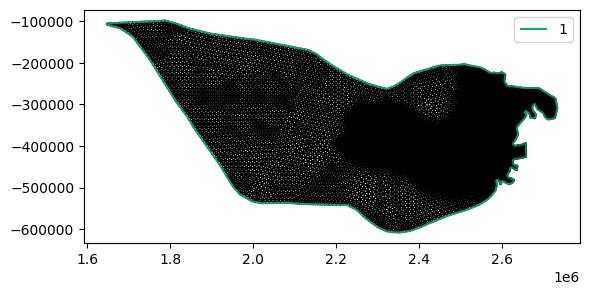

In [3]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(mesh, axes=ax)
ax.legend(loc="upper right");

Read in the velocity data.

In [4]:
measures_filename = icepack.datasets.fetch_measures_antarctica()
measures = xarray.open_dataset(measures_filename)

In [5]:
u_obs = icepack.interpolate((measures["VX"], measures["VY"]), V)

There are some missing points, so just mask them out with 0.
**TODO**: Fix this awfulness.

In [6]:
u_obs.dat.data[np.isnan(u_obs.dat.data_ro)] = 0

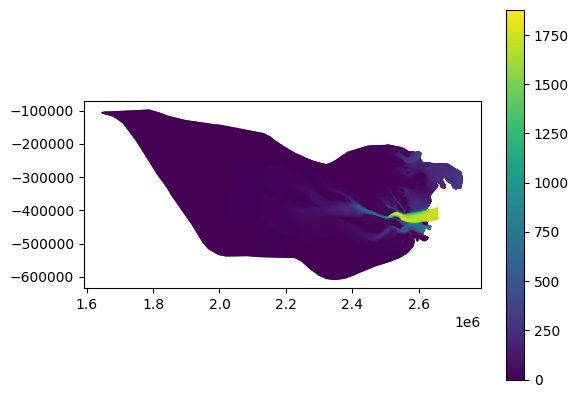

In [7]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(u_obs, axes=ax)
fig.colorbar(colors);

Read in the bed, thickness, and surface elevation data.

In [8]:
bedmachine_filename = icepack.datasets.fetch_bedmachine_antarctica()
bedmachine = xarray.open_dataset(bedmachine_filename)

In [9]:
b = icepack.interpolate(bedmachine["bed"], Q)
h_obs = icepack.interpolate(bedmachine["thickness"], Q)
h_min = firedrake.Constant(10.0)
h = firedrake.Function(Q).interpolate(max_value(h_min, h_obs))

In [10]:
s = firedrake.Function(Q).interpolate(max_value(b + h, (1 - ρ_I / ρ_W) * h))

Plot where the ice appears to be floating or not.

In [11]:
δh = firedrake.Function(Q).interpolate(s - (1 - ρ_I / ρ_W) * h)

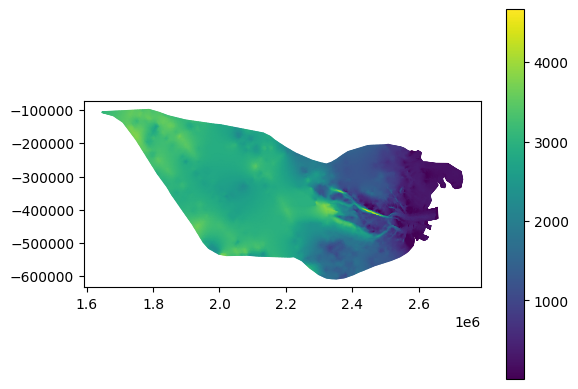

In [12]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(h, axes=ax)
fig.colorbar(colors);

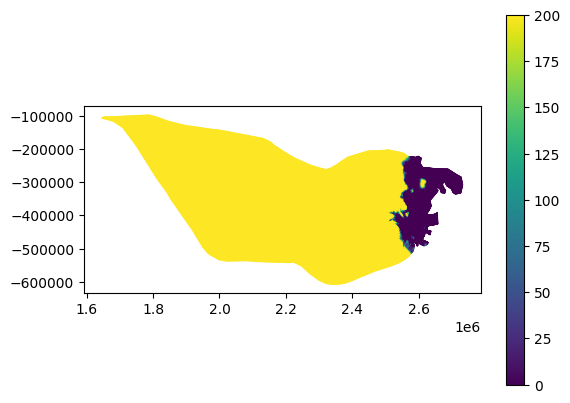

In [13]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(δh, vmin=0.0, vmax=200.0, axes=ax)
fig.colorbar(colors);

Fetch the ALBMAP data set for other variables (see [here](https://doi.pangaea.de/10.1594/PANGAEA.734145)).
The last method call below replaces the coordinate names in the original data set (`"x1"`, `"y1"`) with the coordinate names that the icepack interpolation routines are expecting.
The variable `ghffm` refers to a geothermal heat flux estimate from Fox Maule and others (2005), and `ghfsr` an estimate from Shapiro and Ritzwoller (2004).
We also need the surface temperature and accumulation.

In [14]:
!wget --no-clobber https://store.pangaea.de/Publications/LeBrocq_et_al_2010/ALBMAPv1.nc.zip
!unzip -n ALBMAPv1.nc.zip

/bin/sh: 1: wget: not found
/bin/sh: 1: unzip: not found


In [15]:
albmap = xarray.open_dataset("ALBMAPv1.nc").rename({"x1": "x", "y1": "y"})
[var for var in albmap.data_vars]

['topg',
 'lsrf',
 'usrf',
 'mask',
 'firn',
 'temp',
 'accr',
 'acca',
 'ghffm',
 'ghfsr',
 'mask_plus',
 'glmask',
 'bmask',
 'umask',
 'topg2',
 'lsrf2']

In [16]:
T_surface = icepack.interpolate(albmap["temp"], Q)
a = icepack.interpolate(albmap["acca"], Q)

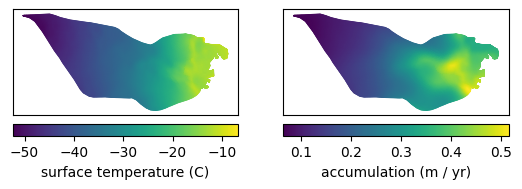

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
for ax in axes:
    ax.set_aspect("equal")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

colors = firedrake.tripcolor(T_surface, axes=axes[0])
fig.colorbar(colors, ax=axes[0], orientation="horizontal", pad=0.025, label="surface temperature (C)")
colors = firedrake.tripcolor(a, axes=axes[1])
fig.colorbar(colors, ax=axes[1], orientation="horizontal", pad=0.025, label="accumulation (m / yr)");

Compute and plot the driving stress but with a smoothing kernel.

In [18]:
α = firedrake.Constant(10e3)
τ_obs = -ρ_I * g * h * grad(s)
τ_d = firedrake.Function(V)
J = 0.5 * (inner(τ_d - τ_obs, τ_d - τ_obs) + α**2 * inner(grad(τ_d), grad(τ_d))) * dx
F = firedrake.derivative(J, τ_d)
firedrake.solve(F == 0, τ_d)

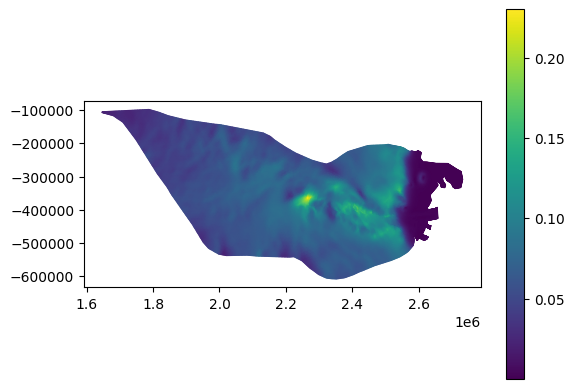

In [19]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(τ_d, axes=ax)
fig.colorbar(colors);

Next we need to make an initial guess for the basal shear stress.
In the interior, we assume that the bed takes up almost all the driving stress.
Where the ice is close to floating, the bed takes up almost none of the driving stress.

In [20]:
δh_c = firedrake.Constant(50.0)
f_interior = firedrake.Constant(0.95)
f = firedrake.conditional(
    δh >= δh_c,
    f_interior,
    0.05,
)

In [21]:
τ_initial = f * sqrt(inner(τ_d, τ_d))
u_min = firedrake.Constant(10.0)
U = max_value(u_min, sqrt(inner(u_obs, u_obs)))
expr = τ_initial / U ** (1 / m)
C_0 = firedrake.Function(Q).interpolate(expr)

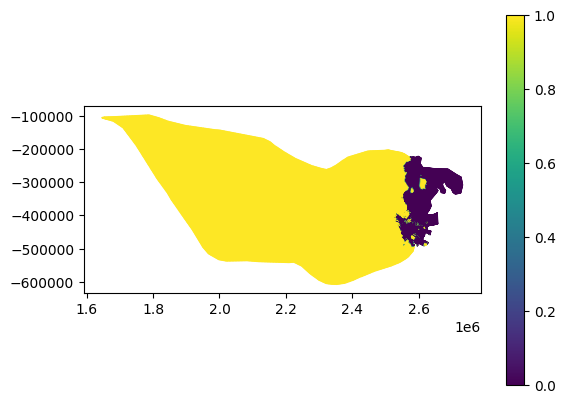

In [22]:
grounded =  icepack.interpolate(δh > 1, Q)
floating =  icepack.interpolate(δh <= 1, Q)
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(grounded, axes=ax)
fig.colorbar(colors);

In [28]:
tauD = firedrake.project(-ρ_I * g * h * grad(s), V)

#
stress = firedrake.sqrt(firedrake.inner(τ_d, τ_d))
print('stress', firedrake.assemble(stress * firedrake.dx))
print(firedrake.assemble(stress * firedrake.dx)/firedrake.assemble(grounded * firedrake.dx)*100)
fraction = firedrake.Constant(0.95)
speed = firedrake.sqrt(firedrake.inner(u_obs, u_obs))
U = max_value(speed, 1)
C = fraction * stress / U**(1/m)
mExp = 1/m + 1
U0 = firedrake.Constant(300)
C = C *  (U0**mExp + U**mExp)**(1/(m+1))
beta_0 = icepack.interpolate(firedrake.sqrt(C) * grounded, Q)



stress 18802445543.422813
6.975340533695828


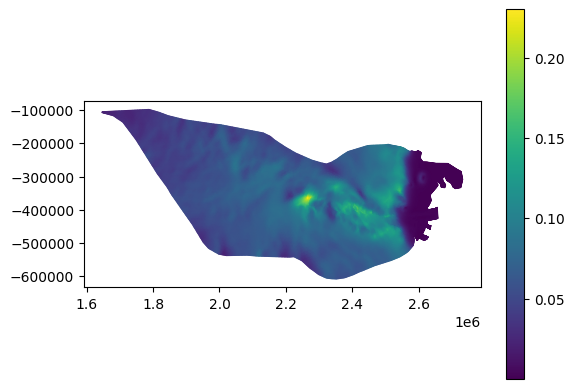

In [29]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(τ_d, axes=ax)
fig.colorbar(colors);

Initial solve for the ice velocity.

NameError: name 'fric1' is not defined

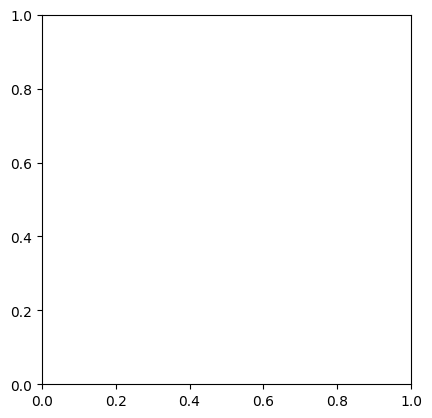

In [31]:
u_0 = Constant(25.0)
def friction1(**kwargs):
    u, ϕ = map(kwargs.get, ("velocity", "log_friction"))
    return m / (m + 1) * C_0 * exp(ϕ) * sqrt(inner(u, u) + u_0**2) ** (1 / m + 1)
u_0 = Constant(25.0)
#fric1 = friction1(velocity=u_obs, log_friction=ϕ)
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(icepack.interpolate(fric1,Q), axes=ax)
fig.colorbar(colors);
print('fric1', firedrake.assemble(fric1* firedrake.dx))

In [32]:
def frictionClosed(beta, u_obs, uThresh):
    m = 3
    U = firedrake.sqrt(firedrake.inner(u_obs, u_obs))
    mEx = 1/m + 1
    return  (beta**2 * U**(1/m))  / ( (uThresh**mEx + U**mEx)**(1/(m+1))) 
    

In [33]:
fric = frictionClosed(beta_0, u_obs, uThresh)
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(icepack.interpolate(beta_0, Q), axes=ax)
fig.colorbar(colors);
print('fric1', firedrake.assemble(fric* firedrake.dx))
print('fric1', firedrake.assemble(fric* firedrake.dx)/ firedrake.assemble(stress * firedrake.dx))

NameError: name 'uThresh' is not defined

NameError: name 'ψ' is not defined

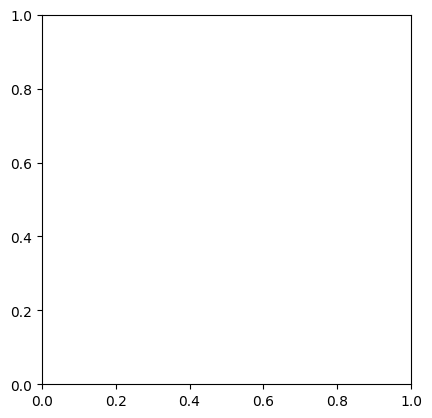

In [34]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(icepack.interpolate(ψ,Q), axes=ax)
fig.colorbar(colors);
print('fric1', firedrake.assemble(fric1* firedrake.dx))

In [38]:
uThresh = firedrake.Constant(300)
ϕ = firedrake.Function(Q)
ψ = firedrake.Function(Q)
from icepack.models.viscosity import viscosity_depth_averaged

T = firedrake.Function(Q).interpolate(T_surface + 273.15)
A_0 = icepack.rate_factor(T)
def viscosity(**kwargs):
    u, h, ψ = map(kwargs.get, ("velocity", "thickness", "log_fluidity"))
    A = A_0 * exp(ψ)
    return viscosity_depth_averaged(velocity=u, thickness=h, fluidity=A)


def friction(**kwargs):
    velocity, grounded, beta, uThresh = map(kwargs.get, ("velocity", "grounded", "beta", "uThresh"))
    m = 3
    C = grounded * beta**2
    mExp = (1./m + 1.)
    U = firedrake.sqrt(firedrake.inner(velocity, velocity))
    return C * ((uThresh**mExp + U**mExp)**(m/(m+1.)) - uThresh)


model = icepack.models.IceStream(friction=friction, viscosity=viscosity)
opts = {
    "dirichlet_ids": [1],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        #"snes_monitor": None,
        "snes_type": "newtonls",
        "snes_linesearch_type": "cp",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)


#u = solver.diagnostic_solve(
#   velocity=u_obs, thickness=h, surface=s, log_friction=ϕ, log_fluidity=ψ)
#)

u = solver.diagnostic_solve(velocity=u_obs, thickness=h, surface=s,
                            log_fluidity=ψ,
                            beta=beta_0, grounded=grounded,
                            uThresh=uThresh)

ConvergenceError: Nonlinear solve failed to converge after 0 nonlinear iterations.
Reason:
   DIVERGED_FNORM_NAN

In [ ]:
friction = modelfunc.schoofFriction
def viscosity(**kwargs):
    u, h, ψ = map(kwargs.get, ("velocity", "thickness", "log_fluidity"))
    A = A_0 * exp(ψ)
    return viscosity_depth_averaged(velocity=u, thickness=h, fluidity=A)
    
forwardModel = icepack.models.IceStream(friction=friction, viscosity=viscosity)
opts = {'dirichlet_ids': [1],
         'diagnostic_solver_parameters':
         {'max_iterations': 150,'tolerance': 1e-10}}
forwardSolver = icepack.solvers.FlowSolver(forwardModel, **opts)
uThresh = firedrake.Constant(300)
#
# initial solve
u0 = forwardSolver.diagnostic_solve(velocity=u_obs, thickness=h,
                                            surface=s, log_fluidity=ψ,
                                            beta=beta, 
                                            grounded=grounded,        
                                            uThresh=uThresh)

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(u, axes=ax)
fig.colorbar(colors);

### Friction estimation problem

Now we'll try and back out the friction.
First we need the error estimates for the velocity.

In [ ]:
σx = icepack.interpolate(measures["ERRX"], Q)
σy = icepack.interpolate(measures["ERRY"], Q)

There are some patches of missing error estimates, so we'll make them very high there in order to down-weight those velocity values.

In [ ]:
σx.dat.data[np.isnan(σx.dat.data_ro)] = 1000.0
σy.dat.data[np.isnan(σy.dat.data_ro)] = 1000.0

In [ ]:
σ = firedrake.Function(Q).interpolate(sqrt(σx**2 + σy**2))
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(σ, vmax=30.0, axes=ax)
fig.colorbar(colors);

Solving the inverse problem requires that we:
1. Define what simulation is being run
2. Create a loss functional, which computes the misfit between the model and data
3. Create a regularization functional, which penalizes unphysical behavior in the solution

In [ ]:
def friction_simulation(ϕ):
    return solver.diagnostic_solve(
        velocity=u_obs,
        thickness=h,
        surface=s,
        log_fluidity=ψ,
        log_friction=ϕ,
    )

In [ ]:
area = firedrake.assemble(Constant(1.0) * dx(mesh))
Ω = Constant(area)

In [ ]:
def loss_functional(u):
    δu = u - u_obs
    return 0.5 / Ω * ((δu[0] / σx)**2 + (δu[1] / σy)**2) * dx

α = Constant(5e3)
def friction_regularization(ϕ):
    return 0.5 / Ω * α**2 * inner(grad(ϕ), grad(ϕ)) * dx

Set up the estimation problem and solver and compute the optimal log-multiplier for the friction.

In [ ]:
from icepack.statistics import (
    StatisticsProblem,
    MaximumProbabilityEstimator,
)

friction_problem = StatisticsProblem(
    simulation=friction_simulation,
    loss_functional=loss_functional,
    regularization=friction_regularization,
    controls=ϕ,
)

In [ ]:
friction_estimator = MaximumProbabilityEstimator(
    friction_problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-1,
    max_iterations=50,
)
ϕ_opt = friction_estimator.solve()

In [ ]:
fig, ax = plt.subplots(size=(10,10))
ax.set_aspect("equal")
colors = firedrake.tripcolor(ϕ_opt, vmin=-1, vmax=+1, cmap="RdBu", axes=ax)
fig.colorbar(colors);

In [ ]:
u_opt = friction_simulation(ϕ_opt)

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(u_opt, axes=ax)
fig.colorbar(colors);

### Viscosity estimation problem

Now we'll go through a similar procedure but to back out the fluidity, with the friction fixed.
Observe that here we're using the optimal solution $\phi_{\text{opt}}$ for the log-friction that we found before.

In [ ]:
def fluidity_simulation(ψ):
    return solver.diagnostic_solve(
        velocity=u_obs,
        thickness=h,
        surface=s,
        log_fluidity=ψ,
        log_friction=ϕ_opt,
    )

In [ ]:
β = Constant(10e3)
def fluidity_regularization(ψ):
    return 0.5 / Ω * β**2 * inner(grad(ψ), grad(ψ)) * dx

In [ ]:
fluidity_problem = StatisticsProblem(
    simulation=fluidity_simulation,
    loss_functional=loss_functional,
    regularization=fluidity_regularization,
    controls=ψ,
)

In [ ]:
fluidity_estimator = MaximumProbabilityEstimator(
    fluidity_problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-1,
    max_iterations=50,
)

In [ ]:
ψ_opt = fluidity_estimator.solve()

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(ψ_opt, vmin=-5, vmax=+5, cmap="RdBu", axes=ax)
fig.colorbar(colors);

In [ ]:
u_opt = fluidity_simulation(ψ_opt)

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(u_opt, axes=ax)
fig.colorbar(colors);

### Porque no los dos

Now let's try to estimate both simultaneously.

In [ ]:
def joint_simulation(controls):
    ϕ, ψ = controls
    return solver.diagnostic_solve(
        velocity=u_obs,
        thickness=h,
        surface=s,
        log_fluidity=ψ,
        log_friction=ϕ,
    )

In [ ]:
def joint_regularization(controls):
    ϕ, ψ = controls
    return 0.5 / Ω * (
        α**2 * inner(grad(ϕ), grad(ϕ)) + β**2 * inner(grad(ψ), grad(ψ))
    ) * dx

In [ ]:
joint_problem = StatisticsProblem(
    simulation=joint_simulation,
    loss_functional=loss_functional,
    regularization=joint_regularization,
    controls=[ϕ_opt, ψ_opt],
)

In [ ]:
joint_estimator = MaximumProbabilityEstimator(
    joint_problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-1,
    max_iterations=50,
)

In [ ]:
ϕ_opt, ψ_opt = joint_estimator.solve()

Save the result to disk.

In [ ]:
with modelfunc.CheckpointFileNFS("denman.h5", "w") as chk:
    chk.save_mesh(mesh)
    chk.save_function(C_0, name="baseline_friction")
    chk.save_function(ϕ_opt, name="log_friction_multiplier")
    chk.save_function(ψ_opt, name="log_fluidity_multiplier")
    chk.h5pyfile.attrs["min_speed"] = 25.0